In [1]:
import math
from random import randint, choice
from gym.envs.classic_control import CartPoleEnv
import tensorflow as tf
import pandas as pd
import numpy as np
import heapq
from random import random, sample
from IPython import display
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
batch_size = 256
T = batch_size*10
GAMMA = 0.5
learning_rate = 0.001

In [3]:
class Transaction:
    columns = ['state', 'action', 'reward', 'next_state', 'done', 'label']
    actions = [[0, 1], [1, 0]]
    def __init__(self, item):
        self.item = dict(zip(Transaction.columns, item))
        
    def  __lt__(self, other):
        #sort by time
        return self.item['id'] < other.item['id']
        #sort by gained label
        #return self.item['label'] < other.item['label']
    
    def __repr__(self):
        return str(self.item)
    
    def value(self):
        return self.item['state'] + Transaction.actions[self.item['action']]
    
    def __getitem__(self, key):
        return self.item[key]
    
    def __setitem__(self, key, value):
        self.item[key] = value

class Memory:
    def __init__(self, max_size):
        MAX_TRANSACTION = Transaction(Transaction.columns)
        MAX_TRANSACTION.item['id'] = -1
        self.d = []
        self.id = 0
        self.max_size = max_size
        
    def insert(self, item):
        self.id += 1
        item['id'] = self.id
        #print(self.d)

        if len(self.d) == self.max_size:
            heapq.heapreplace(self.d, item)
        else:
            heapq.heappush(self.d, item)

    def batch(self, n):
        if len(self.d) > n:
            batch = np.array(sample(self.d, n))
            return batch
        else:
            return np.array(self.d)
        
def transform_to_Q_input(batch):
    return np.array([transaction.value() for transaction in batch])

def get_labels(batch):
    return np.array([transaction['label'] for transaction in batch])

def test():
    D = Memory(2)
    item1 = Transaction([np.array([0,1,2,3]), 1,0,np.array([3,2,1,0]),0,10])
    item2 = Transaction([np.array([0,1,2,3]), 1,0,np.array([3,2,1,0]),0,10])
    item3 = Transaction([np.array([0,1,2,3]), 1,0,np.array([3,2,1,0]),0,10])

    D.insert(item1)
    D.insert(item2)
    D.insert(item3)

    print(D.d, D.batch(2), D.d)
    item = Transaction([np.array([-1,1,2,3]), 1,0,np.array([3,2,1,0]),0,10])
    D.insert(item)
    print(D.d, D.batch(1))

In [39]:
class QNetwork:
    def __init__(self):
        self.state_size = 4
        self.action_size = 2
        self.input_size = self.state_size + self.action_size
        self.units = 32
        self.n_layers = 4
        self.output_size = 1
        self.model_folder = './model/'
        
        self.input = tf.placeholder(shape=(None, self.input_size), dtype=tf.float32)
        self.label = tf.placeholder(shape=(None), dtype=tf.float32)
        self.global_step = tf.Variable(0, dtype=tf.int32)
        
        self.build_network()
        self.sess = sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 1}))
        self.target_Q_sess = sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 1}))
        
        self.sess.run(tf.global_variables_initializer())
        self.target_Q_sess.run(tf.global_variables_initializer())
        
        self.saver = tf.train.Saver()

    def build_network(self):
        layers = [0]*self.n_layers
        layers[0] = tf.layers.dense(inputs=self.input, units=self.units, activation=tf.nn.relu, name='layer_0')
        for i in range(self.n_layers-1):
            layers[i+1] = tf.layers.dense(inputs=layers[i], units=self.units, activation=tf.nn.relu, name='layer_%d'%(i+1))
        
        self.qvalue = tf.layers.dense(inputs=layers[-1], units=self.output_size)

        self.loss = tf.losses.mean_squared_error(labels=self.label, predictions=self.qvalue)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        self.train_step = self.do_clipping(self.loss, optimizer)
        #self.train_step = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        self.best_action = tf.argmax(self.qvalue, axis=0)
        
    def do_clipping(self, loss, optimizer):
        grad_vars = optimizer.compute_gradients(loss)
        self.grad_vars = [
          (tf.clip_by_norm(grad, clip_norm=10), var)
          for grad, var in grad_vars if grad is not None
        ]
        self.grad_dict = dict([
          [var.name, grad]
          for grad, var in self.grad_vars
        ])

        train_step = optimizer.apply_gradients(self.grad_vars, global_step=self.global_step)
        return train_step

    def get_Q_value(self, batch):
        return self.target_Q_sess.run(self.qvalue, feed_dict={self.input: batch})
        
    def get_best_action(self, state):
        batch = [None, None]
        batch[0] = state + [0, 1]
        batch[1] = state + [1, 0]
        #print state, np.array(batch).shape
        
        best_action = self.sess.run(self.best_action, feed_dict={self.input: batch})
        assert len(best_action) == 1
        return best_action[0]
    
    def update(self, batch):
        inputs = transform_to_Q_input(batch)
        labels = get_labels(batch)
        return self.sess.run([self.train_step, self.loss], feed_dict={self.input: inputs, self.label: labels})
    
    def reload_target_Q_network(self):
        self.saver.restore(self.target_Q_sess, tf.train.latest_checkpoint(self.model_folder))
        
    def save(self):
        self.saver.save(self.sess, self.model_folder, global_step=self.global_step)
        

In [38]:
Q.saver.restore(Q.target_Q_sess, tf.train.latest_checkpoint('./model'))

INFO:tensorflow:Restoring parameters from ./model/latest-0


In [15]:
def add_label(batch, Q, gamma):
    _batch = transform_to_Q_input(batch)
    qvalues = Q.get_Q_value(_batch)
    for qvalue,transaction in zip(qvalues, batch):
        if not transaction['done']:
            transaction['label'] = transaction['reward'] + qvalue*gamma
        else:
            transaction['label'] = transaction['reward']

In [16]:
def plot(metrics):
    x = [i for i in range(len(metrics['action'][0]))]
    #plt.plot(x, metrics['loss'], 'b', x, metrics['action'][0], 'r', x, metrics['action'][1], 'y')
    #plt.plot(x, metrics['loss'], 'b')
    plt.plot(x, metrics['action'][0], 'r', x, metrics['action'][1], 'y')
    display.display(plt.gcf())
    display.clear_output(wait=True)

KeyboardInterrupt: 

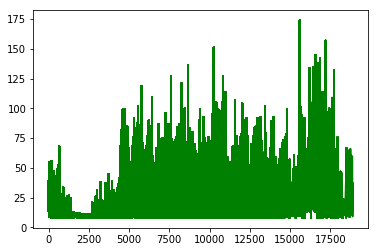

In [42]:
tf.reset_default_graph()

D = Memory(T)
Q = QNetwork()

env = CartPoleEnv()
#env.theta_threshold_radians = 2 * math.pi * 1/4
state = env.reset()
state = state.tolist()

metrics  = {}
metrics['loss'] = [0]
metrics['action'] = [[0], [0]]
metrics['best_action'] = [[0], [0]]
metrics['round_length'] = []

t = 0
one_round = []
mu = 1.0

for rid in range(2000000):
    #env.render()
    if random() < mu:
        action = env.action_space.sample()
    else:
        action = Q.get_best_action(state)
    
    next_state, reward, done, _ = env.step(action) # take a random action
    next_state = next_state.tolist()
    
    transaction = Transaction((state, action, reward, next_state, done, -1))
    #D.insert(transaction)
    state = next_state
    one_round.append(transaction)
    t += 1
    
    best_action = Q.get_best_action(transaction['state'])
    action = env.action_space.sample()
    metrics['action'][action].append(metrics['action'][action][-1]+1)
    metrics['action'][action ^ 1].append(metrics['action'][action ^ 1][-1])
    
    metrics['best_action'][best_action].append(metrics['best_action'][best_action][-1]+1)
    metrics['best_action'][best_action ^ 1].append(metrics['best_action'][best_action ^ 1][-1])

    batch = D.batch(batch_size)
    if batch.any():
        add_label(batch, Q, GAMMA)
        _, loss = Q.update(batch)
        
        metrics['loss'].append(loss)
    
    #print(transaction, batch)    
    if done:
        reward = 0
        for transaction in reversed(one_round):
            reward += transaction['reward']
            transaction['reward'] = reward
            D.insert(transaction)
            
        metrics['round_length'].append(len(one_round))
        one_round = []
        
        mu *= 0.993
        
        state = env.reset()
        state = state.tolist()
        
    if rid % 1000 == 0:
        #plt.plot(metrics['action'][0], metrics['action'][1], 'g', metrics['best_action'][0], metrics['best_action'][1], 'y')
        Q.save()
        Q.reload_target_Q_network()


        print(mu, rid)
        plt.plot(metrics['round_length'], 'g')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        #plot(metrics)
        
        

In [ ]:
plt.plot(metrics['round_length'])
#plt.plot(metrics['action'][0], metrics['action'][1], 'g', metrics['best_action'][0], metrics['best_action'][1], 'y')

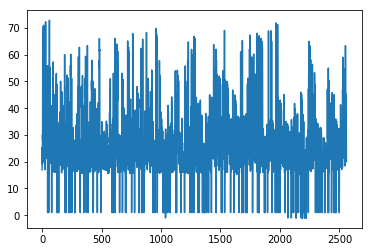

In [30]:
exp = pd.DataFrame([[t['action'], t['reward'], t['done'], t['label']] for t in D.d], columns=['action', 'reward', 'done', 'label'])
plt.plot(exp['label'].iloc[:3000])

In [42]:
env.reset()
for _ in range(1000):
    env.render()
    action = Q.get_best_action(state)
    #action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action) # take a random action
    state = next_state.tolist()
    print(next_state, reward, action)
    
    if done:
        env.reset()

[-0.03032141 -0.23850692 -0.01934585  0.26213464] 1.0 0
[-0.03509155 -0.43334745 -0.01410316  0.54865343] 1.0 0
[-0.0437585  -0.62826848 -0.00313009  0.8368597 ] 1.0 0
[-0.05632387 -0.82334754  0.0136071   1.12855661] 1.0 0
[-0.07279082 -1.01864506  0.03617824  1.42547613] 1.0 0
[-0.09316372 -1.21419498  0.06468776  1.72924316] 1.0 0
[-0.11744762 -1.40999361  0.09927262  2.04133177] 1.0 0
[-0.1456475  -1.60598615  0.14009926  2.36301137] 1.0 0
[-0.17776722 -1.80205068  0.18735949  2.69528122] 1.0 0
[-0.21380823 -1.99797968  0.24126511  3.03879341] 1.0 0
[ 0.04861084 -0.15596074 -0.02052949  0.29518923] 1.0 0
[ 0.04549163 -0.35078409 -0.01462571  0.58132742] 1.0 0
[ 0.03847594 -0.54569809 -0.00299916  0.86936734] 1.0 0
[ 0.02756198 -0.74077911  0.01438819  1.16110581] 1.0 0
[ 0.0127464  -0.9360855   0.0376103   1.45826505] 1.0 0
[-0.00597531 -1.13164808  0.0667756   1.7624563 ] 1.0 0
[-0.02860827 -1.32745885  0.10202473  2.07513529] 1.0 0
[-0.05515745 -1.52345721  0.14352744  2.39754731

In [32]:
action = env.action_space.sample()
print(action)
env.step(action)

0
WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


(array([-0.1831761 , -2.19583504,  0.28953511,  3.37880674]), 0.0, True, {})